In [1]:
import cv2, os
import numpy as np
from math import sqrt, ceil, floor
from matplotlib import pyplot as plt;
from matplotlib import rc;
from matplotlib.colors import hsv_to_rgb

In /home/hde/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/hde/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/hde/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
# Returns the relative path of all pictures in the specified folder.
def readAllImages(root):
    pictureNames = os.listdir("./{0}/".format(root))
    for i in range(len(pictureNames)):
        pictureNames[i] = "./{0}/".format(root) + pictureNames[i]
    return pictureNames

In [3]:
class Patch:
    def __init__(self,id,path,path_rgb):
        self.id = id
        self.path = path
        self.path_rgb = path_rgb
        self.upper_edge_type = ""
        self.right_edge_type = ""
        self.left_edge_type = ""
        self.lower_edge_type = ""
        self.upper_pixel_ct = 0
        self.right_pixel_ct = 0
        self.left_pixel_ct = 0
        self.lower_pixel_ct = 0
        self.upper_hypotenuse_length = 0
        self.lower_hypotenuse_length = 0
        self.right_hypotenuse_length = 0
        self.left_hypotenuse_length = 0

    def readImage(self):
        self.image = cv2.imread("{0}".format(self.path),1)
        self.originalImage = np.copy(self.image)
        self.originalImage_rgb = cv2.imread("{0}".format(self.path_rgb),1)
        self.grayScale = cv2.cvtColor(self.image,cv2.COLOR_BGR2GRAY)
        self.grayScale_f = np.float32(self.grayScale)
    
    def getId(self):
        print(self.id)
        
    def printEdgeImage(self):
        plt.imshow(self.image)
        
    def getEdgeImage(self):
        return self.image
    
    def getOriginalImage(self):
        return self.originalImage
    
    def getOriginalImageRGB(self):
        return self.originalImage_rgb
    
    def getEdgeTypes(self):
        return self.upper_edge_type,self.right_edge_type,self.lower_edge_type,self.left_edge_type
    
    def getEdgeSlopes(self):
        return self.upper_slope,self.right_slope,self.lower_slope,self.left_slope
    
    def calculateHypotenuseLengths(self):
        self.upper_hypotenuse_length = sqrt(pow(self.u_l[0]-self.u_r[0],2)+pow(self.u_l[1]-self.u_r[1],2))
        self.lower_hypotenuse_length = sqrt(pow(self.l_l[0]-self.l_r[0],2)+pow(self.l_l[1]-self.l_r[1],2))
        self.right_hypotenuse_length = sqrt(pow(self.u_r[0]-self.l_r[0],2)+pow(self.u_r[1]-self.l_r[1],2))
        self.left_hypotenuse_length = sqrt(pow(self.u_l[0]-self.l_l[0],2)+pow(self.u_l[1]-self.l_l[1],2))
        
    def findCorners(self):
        self.cornered = cv2.cornerHarris(self.grayScale_f,5,3,0.12)
        
        #Set initial values for corners.
        #This values are relative values w.r.t whole image.
        self.height,self.width = self.grayScale.shape[:]
        self.u_l = self.grayScale.shape[:] #Upper left
        self.l_l = [0,self.width]          #Lower left
        self.u_r = [self.height,0]         #Upper right
        self.l_r = [0,0]                   #Lower right

        #Iterate over all pixels.
        for j in range(self.width):
            for i in range(self.height):
                if self.cornered[i,j] > 0.01*self.cornered.max():
                    #Check whether the pixel is included by the patch.
                    if self.grayScale[i,j] == 255:
                        if np.sum(self.u_l) > i+j:
                            self.u_l = (i,j)
                        elif (self.height-self.l_l[0])+(self.l_l[1]) > (self.height-i)+(j):
                            self.l_l = (i,j)
                        elif self.u_r[0]+(self.width-self.u_r[1]) > (i)+(self.width-j):
                            self.u_r = (i,j)
                        elif np.sum(self.l_r) < i+j:
                            self.l_r = (i,j)
    
    
    def drawCorners(self,gain):
        #Gain is used for visual purposes only. It specifies how much colored pixels added to corners.
        #gain = 2
        self.image[self.u_l[0]-gain:self.u_l[0]+gain,self.u_l[1]-gain:self.u_l[1]+gain] = [0,255,0] # Upper left = Green
        self.image[self.l_l[0]-gain:self.l_l[0]+gain,self.l_l[1]-gain:self.l_l[1]+gain] = [0,255,255] # Lower left = Cyan
        self.image[self.u_r[0]-gain:self.u_r[0]+gain,self.u_r[1]-gain:self.u_r[1]+gain] = [255,0,255] # Upper right = Purple
        self.image[self.l_r[0]-gain:self.l_r[0]+gain,self.l_r[1]-gain:self.l_r[1]+gain] = [255,0,0] # Lower right = Red 
    
    
    def findContours(self):
        self.contours, hierarchy = cv2.findContours(self.grayScale, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        
        # Find the upper left corner in the contour.
        start = 0
        new_contours = np.copy(self.contours)
        for i in range(len(self.contours[0])):
            if np.array_equal(np.array([self.u_l[1],self.u_l[0]],dtype=np.int32), self.contours[0][i][0]):
                start = i

        # Rearrange the contour points starting with the upper left corner.
        new_contours=np.vstack((self.contours[0][start:],self.contours[0][0:start]))
        new_contours = new_contours.reshape(new_contours.shape[0],2)
        self.contours = new_contours
        
        # Find whether the order of pixels follows clockwise or counter clockwise.
        flag = ""
        for i in self.contours:
            if np.array_equal(i[::-1], self.l_l):
                flag = "l_l"
                break
            elif np.array_equal(i[::-1], self.u_r):
                flag = "u_r"
                break

        # Make sure that the pixels follow clockwise order.
        if flag == "l_l":
            self.contours = self.contours[::-1]
        
    #Found indices are relative to the contour.
    def findEdgePixelCounts(self):
        # Draw the upper edge with green color.
        for index in range(len(self.contours)):
            self.image[self.contours[index][1],self.contours[index][0]] = [0,255,0]
            self.upper_pixel_ct += 1
            if np.array_equal(self.contours[index][::-1],self.u_r):
                self.u_r_index = index
                break

        # Draw the right edge with purple color.
        for index in range(self.u_r_index,len(self.contours)):
            self.image[self.contours[index][1],self.contours[index][0]] = [255,0,255]
            self.right_pixel_ct += 1
            if np.array_equal(self.contours[index][::-1],self.l_r):
                self.l_r_index = index
                break

        # Draw the lower edge with red color.
        for index in range(self.l_r_index,len(self.contours)):
            self.image[self.contours[index][1],self.contours[index][0]] = [255,0,0]
            self.lower_pixel_ct += 1
            if np.array_equal(self.contours[index][::-1],self.l_l):
                self.l_l_index = index
                break

        # Draw the left edge with cyan color.
        for index in range(self.l_l_index,len(self.contours)):
            self.image[self.contours[index][1],self.contours[index][0]] = [0,255,255]
            self.left_pixel_ct += 1
            
    
    def calculateEdgeType(self):
        #Upper edge ----------------------------------------------------
        max = np.amax(self.contours[0:self.u_r_index],axis=0)
        min = np.amin(self.contours[0:self.u_r_index],axis=0)
        x1,y1 = self.u_l[:]
        x2,y2 = self.u_r[:]
        if max[1] - min[1] <= 5:
            self.upper_edge_type = "flat"
        else:
            black_ct = 0
            white_ct = 0
            #We take y because its interval is larger than x on horizontal edges.
            for y in range(y1,y2):
                x = floor((y-y1)*((x1-x2)/(y1-y2))+x1)
                if np.array_equal(self.image[x,y],[0,0,0]):
                    black_ct += 1
                else: white_ct += 1
                self.image[x,y] = [0,255,0]
            if black_ct > white_ct:
                self.upper_edge_type = "convex"
            else: self.upper_edge_type = "concave"
        self.upper_slope = (x1-x2)/(y1-y2)
            
        #Lower edge ------------------------------------------------------
        max = np.amax(self.contours[self.l_r_index:self.l_l_index],axis=0)
        min = np.amin(self.contours[self.l_r_index:self.l_l_index],axis=0)
        x1,y1 = self.l_l[:]
        x2,y2 = self.l_r[:]
        if max[1] - min[1] <= 5:
            self.lower_edge_type = "flat"
        else:
            black_ct = 0
            white_ct = 0
            
            #We take y because its interval is larger than x on horizontal edges.
            for y in range(y1,y2):
                x = floor((y-y1)*((x1-x2)/(y1-y2))+x1)
                if np.array_equal(self.image[x,y],[0,0,0]):
                    black_ct += 1
                else: white_ct += 1
                self.image[x,y] = [255,0,0]
            if black_ct > white_ct:
                self.lower_edge_type = "convex"
            else: self.lower_edge_type = "concave"
        self.lower_slope = (x1-x2)/(y1-y2)
        
        #Right edge ------------------------------------------------------
        max = np.amax(self.contours[self.u_r_index:self.l_r_index],axis=0)
        min = np.amin(self.contours[self.u_r_index:self.l_r_index],axis=0)
        x1,y1 = self.u_r[:]
        x2,y2 = self.l_r[:]
        if max[0] - min[0] <= 5:
            self.right_edge_type = "flat"
        else:
            black_ct = 0
            white_ct = 0
            
            #We take x because its interval is larger than y on vertical edges.
            for x in range(x1,x2):
                y = floor((x-x1)*((y1-y2)/(x1-x2))+y1)
                if np.array_equal(self.image[x,y],[0,0,0]):
                    black_ct += 1
                else: white_ct += 1
                self.image[x,y] = [255,0,255]
            if black_ct > white_ct:
                self.right_edge_type = "convex"
            else: self.right_edge_type = "concave"
        self.right_slope = (y1-y2)/(x1-x2)
        
        #Left edge ------------------------------------------------------
        max = np.amax(self.contours[self.l_l_index:-1],axis=0)
        min = np.amin(self.contours[self.l_l_index:-1],axis=0)
        x1,y1 = self.u_l[:]
        x2,y2 = self.l_l[:]
        if max[0] - min[0] <= 5:
            self.left_edge_type = "flat"
        else:
            black_ct = 0
            white_ct = 0
            
            #We take x because its interval is larger than y on vertical edges.
            for x in range(x1,x2):
                y = floor((x-x1)*((y1-y2)/(x1-x2))+y1)
                if np.array_equal(self.image[x,y],[0,0,0]):
                    black_ct += 1
                else: white_ct += 1
                self.image[x,y] = [0,255,255]
            if black_ct > white_ct:
                self.left_edge_type = "convex"
            else: self.left_edge_type = "concave"
        self.left_slope = (y1-y2)/(x1-x2)
    
    def pipeLine(self):
        self.readImage()
        self.findCorners()
        self.drawCorners(gain=3)
        self.findContours()
        self.findEdgePixelCounts()
        self.calculateHypotenuseLengths()
        self.calculateEdgeType()


In [4]:
class Puzzle:
    def __init__(self,horizontal,vertical,patch_list):
        #Pay attention to x,y. They should be reversed in list operations.
        self.x = horizontal
        self.y = vertical
        self.board = [self.x*[0] for i in range(self.y)]
        self.patch_list = patch_list
        self.pixel_ct_max_error = 10
        self.slope_max_error = 0.03
        self.hypotenuse_max_error = 4
    
    def getBoard(self):
        return self.board
    
    def findCornerPatches(self):
        deleted_indices = []
        for i in range(len(self.patch_list)):
            if self.patch_list[i].left_edge_type == self.patch_list[i].upper_edge_type == "flat":
                self.board[0][0] = self.patch_list[i]
                deleted_indices.append(i)
                print("Upper left corner: {0}".format(i))
            elif self.patch_list[i].upper_edge_type == self.patch_list[i].right_edge_type == "flat":
                self.board[0][self.x-1] = self.patch_list[i]
                deleted_indices.append(i)
                print("Upper right corner: {0}".format(i))
            elif self.patch_list[i].right_edge_type == self.patch_list[i].lower_edge_type == "flat":
                self.board[self.y-1][self.x-1] = self.patch_list[i]
                deleted_indices.append(i)
                print("Lower right corner: {0}".format(i))
            elif self.patch_list[i].lower_edge_type == self.patch_list[i].left_edge_type == "flat":
                self.board[self.y-1][0] = self.patch_list[i]
                deleted_indices.append(i)
                print("Lower left corner: {0}".format(i))
        self.removeFoundPatchesFromList(deleted_indices)
        
    def removeFoundPatchesFromList(self,deleted_indices):
        for i in deleted_indices[::-1]:
            del self.patch_list[i]
            
    def findUpperPatches(self):
        upper_indices = []
        for i in range(len(self.patch_list)):
            if self.patch_list[i].upper_edge_type == "flat":
                upper_indices.append(i)
                print(i)
        
        #Can be optimized later... Delete the matched indices to reduce complexity.
        leftmost = 0
        for h_ct in range(self.x-2):
            for i in upper_indices:
                if self.board[0][leftmost].right_edge_type == "convex" and self.patch_list[i].left_edge_type == "concave" or\
                self.board[0][leftmost].right_edge_type == "concave" and self.patch_list[i].left_edge_type == "convex":
                    if abs(self.board[0][leftmost].right_pixel_ct - self.patch_list[i].left_pixel_ct) < self.pixel_ct_max_error and\
                    abs(self.board[0][leftmost].right_hypotenuse_length - self.patch_list[i].left_hypotenuse_length) < self.hypotenuse_max_error and\
                    abs(self.board[0][leftmost].right_slope - self.patch_list[i].left_slope) < self.slope_max_error:
                        leftmost += 1
                        self.board[0][leftmost] = self.patch_list[i]
                        print("upper match w.r.t left-right edge")
                        print(i)
                        if leftmost == self.x-2:
                            if self.board[0][leftmost].right_edge_type == "convex" and self.board[0][-1].left_edge_type == "concave" or\
                            self.board[0][leftmost].right_edge_type == "concave" and self.board[0][-1].left_edge_type == "convex":
                                if abs(self.board[0][leftmost].right_pixel_ct - self.board[0][-1].left_pixel_ct) < self.pixel_ct_max_error and\
                                abs(self.board[0][leftmost].right_hypotenuse_length - self.board[0][-1].left_hypotenuse_length) < self.hypotenuse_max_error and\
                                abs(self.board[0][leftmost].right_slope - self.board[0][-1].left_slope) < self.slope_max_error:
                                    print("Upper row is complete")
                            else: print("Upper row does not match.")
                        break
        self.removeFoundPatchesFromList(upper_indices)

    def findLowerPatches(self):
        lower_indices = []
        for i in range(len(self.patch_list)):
            if self.patch_list[i].lower_edge_type == "flat":
                lower_indices.append(i)
                print(i)
        
        leftmost = 0
        for h_ct in range(self.x-2):
            for i in lower_indices:
                if self.board[-1][leftmost].right_edge_type == "convex" and self.patch_list[i].left_edge_type == "concave" or\
                self.board[-1][leftmost].right_edge_type == "concave" and self.patch_list[i].left_edge_type == "convex":
                    if abs(self.board[-1][leftmost].right_pixel_ct - self.patch_list[i].left_pixel_ct) < self.pixel_ct_max_error and\
                    abs(self.board[-1][leftmost].right_hypotenuse_length - self.patch_list[i].left_hypotenuse_length) < self.hypotenuse_max_error and\
                    abs(self.board[-1][leftmost].right_slope - self.patch_list[i].left_slope) < self.slope_max_error:
                        leftmost += 1
                        self.board[-1][leftmost] = self.patch_list[i]
                        print("lower match w.r.t left-right edge")
                        print(i)
                        if leftmost == self.x-2:
                            if self.board[-1][leftmost].right_edge_type == "convex" and self.board[-1][-1].left_edge_type == "concave" or\
                            self.board[-1][leftmost].right_edge_type == "concave" and self.board[-1][-1].left_edge_type == "convex":
                                if abs(self.board[-1][leftmost].right_pixel_ct - self.board[-1][-1].left_pixel_ct) < self.pixel_ct_max_error and\
                                abs(self.board[-1][leftmost].right_hypotenuse_length - self.board[-1][-1].left_hypotenuse_length) < self.hypotenuse_max_error and\
                                abs(self.board[-1][leftmost].right_slope - self.board[-1][-1].left_slope) < self.slope_max_error:
                                    print("Lower row is complete")
                            else: print("Lower row does not match.")
                        break
        self.removeFoundPatchesFromList(lower_indices)  
            
            
    def findLeftPatches(self):
        left_indices = []
        for i in range(len(self.patch_list)):
            if self.patch_list[i].left_edge_type == "flat":
                left_indices.append(i)
                print(i)
                
        uppermost = 0
        for v_ct in range(self.y-2):
            for i in left_indices:
                if self.board[uppermost][0].lower_edge_type == "convex" and self.patch_list[i].upper_edge_type == "concave" or\
                self.board[uppermost][0].lower_edge_type == "concave" and self.patch_list[i].upper_edge_type == "convex":
                    if abs(self.board[uppermost][0].lower_pixel_ct - self.patch_list[i].upper_pixel_ct) < self.pixel_ct_max_error and\
                    abs(self.board[uppermost][0].lower_hypotenuse_length - self.patch_list[i].upper_hypotenuse_length) < self.hypotenuse_max_error and\
                    abs(self.board[uppermost][0].lower_slope - self.patch_list[i].upper_slope) < self.slope_max_error:
                        uppermost += 1
                        self.board[uppermost][0] = self.patch_list[i]
                        print("left match w.r.t lower-upper edge")
                        print(i)
                        if uppermost == self.y-2:
                            if self.board[uppermost][0].lower_edge_type == "convex" and self.board[-1][0].upper_edge_type == "concave" or\
                            self.board[uppermost][0].lower_edge_type == "concave" and self.board[-1][0].upper_edge_type == "convex":
                                if abs(self.board[uppermost][0].lower_pixel_ct - self.board[-1][0].upper_pixel_ct) < self.pixel_ct_max_error and\
                                abs(self.board[uppermost][0].lower_hypotenuse_length - self.board[-1][0].upper_hypotenuse_length) < self.hypotenuse_max_error and\
                                abs(self.board[uppermost][0].lower_slope - self.board[-1][0].upper_slope) < self.slope_max_error:
                                    print("Left row is complete")
                            else: print("Left row does not match.")
                        break
        self.removeFoundPatchesFromList(left_indices)
        
        
    def findRightPatches(self):
        right_indices = []
        for i in range(len(self.patch_list)):
            if self.patch_list[i].right_edge_type == "flat":
                right_indices.append(i)
                print(i)
        
        uppermost = 0
        for v_ct in range(self.y-2):
            for i in right_indices:
                if self.board[uppermost][-1].lower_edge_type == "convex" and self.patch_list[i].upper_edge_type == "concave" or\
                self.board[uppermost][-1].lower_edge_type == "concave" and self.patch_list[i].upper_edge_type == "convex":
                    if abs(self.board[uppermost][-1].lower_pixel_ct - self.patch_list[i].upper_pixel_ct) < self.pixel_ct_max_error and\
                    abs(self.board[uppermost][-1].lower_hypotenuse_length - self.patch_list[i].upper_hypotenuse_length) < self.hypotenuse_max_error and\
                    abs(self.board[uppermost][-1].lower_slope - self.patch_list[i].upper_slope) < self.slope_max_error:
                        uppermost += 1
                        self.board[uppermost][-1] = self.patch_list[i]
                        print("right match w.r.t lower-upper edge")
                        print(i)
                        if uppermost == self.y-2:
                            if self.board[uppermost][-1].lower_edge_type == "convex" and self.board[-1][-1].upper_edge_type == "concave" or\
                            self.board[uppermost][-1].lower_edge_type == "concave" and self.board[-1][-1].upper_edge_type == "convex":
                                if abs(self.board[uppermost][-1].lower_pixel_ct - self.board[-1][-1].upper_pixel_ct) < self.pixel_ct_max_error and\
                                abs(self.board[uppermost][-1].lower_hypotenuse_length - self.board[-1][-1].upper_hypotenuse_length) < self.hypotenuse_max_error and\
                                abs(self.board[uppermost][-1].lower_slope - self.board[-1][-1].upper_slope) < self.slope_max_error:
                                    print("Right row is complete")
                            else: print("Right row does not match.")
                        break
        self.removeFoundPatchesFromList(right_indices)
        
        
    def findInnerPatches(self):
        for i in range(1,self.x-1):
            for j in range(1,self.y-1):
                for k in range(len(self.patch_list)):
                    horizontal_flag = True
                    vertical_flag = True
                    #Check w.r.t left
                    if self.board[j][i-1].right_edge_type == "convex" and self.patch_list[k].left_edge_type == "concave" or\
                    self.board[j][i-1].right_edge_type == "concave" and self.patch_list[k].left_edge_type == "convex":
                        if abs(self.board[j][i-1].right_pixel_ct - self.patch_list[k].left_pixel_ct) < self.pixel_ct_max_error and\
                        abs(self.board[j][i-1].right_hypotenuse_length - self.patch_list[k].left_hypotenuse_length) < self.hypotenuse_max_error and\
                        abs(self.board[j][i-1].right_slope - self.patch_list[k].left_slope) < self.slope_max_error:
                            #Check w.r.t upper
                            if self.board[j-1][i].lower_edge_type == "convex" and self.patch_list[k].upper_edge_type == "concave" or\
                            self.board[j-1][i].lower_edge_type == "concave" and self.patch_list[k].upper_edge_type == "convex":
                                if abs(self.board[j-1][i].lower_pixel_ct - self.patch_list[k].upper_pixel_ct) < self.pixel_ct_max_error and\
                                abs(self.board[j-1][i].lower_hypotenuse_length - self.patch_list[k].upper_hypotenuse_length) < self.hypotenuse_max_error and\
                                abs(self.board[j-1][i].lower_slope - self.patch_list[k].upper_slope) < self.slope_max_error:
                                    print("Upper & Left match")
                                    #If it is the last patch in this row, check if it matches with the last patch.
                                    if i == self.x-2:
                                        if self.patch_list[k].right_edge_type == "convex" and self.board[j][-1].left_edge_type == "concave" or\
                                        self.patch_list[k].right_edge_type == "concave" and self.board[j][-1].left_edge_type == "convex":
                                            if abs(self.patch_list[k].right_pixel_ct - self.board[j][-1].left_pixel_ct) < self.pixel_ct_max_error and\
                                            abs(self.patch_list[k].right_hypotenuse_length - self.board[j][-1].left_hypotenuse_length) < self.hypotenuse_max_error and\
                                            abs(self.patch_list[k].right_slope - self.board[j][-1].left_slope) < self.slope_max_error:
                                                print("Row-{0} is horizontally valid".format(j))
                                        else: 
                                            print("Row-{0} is horizontally invalid".format(j))
                                            horizontal_flag = False
                                    #If it is the last patch in this column, check if it matches with the last patch.
                                    if j == self.y-2:
                                        if self.patch_list[k].lower_edge_type == "convex" and self.board[-1][i].upper_edge_type == "concave" or\
                                        self.patch_list[k].lower_edge_type == "concave" and self.board[-1][i].upper_edge_type == "convex":
                                            if abs(self.patch_list[k].lower_pixel_ct - self.board[-1][i].upper_pixel_ct) < self.pixel_ct_max_error and\
                                            abs(self.patch_list[k].lower_hypotenuse_length - self.board[-1][i].upper_hypotenuse_length) < self.hypotenuse_max_error and\
                                            abs(self.patch_list[k].lower_slope - self.board[-1][i].upper_slope) < self.slope_max_error:
                                                print("Column-{0} is vertically valid".format(i))
                                        else: 
                                            print("Column-{0} is vertically invalid".format(i))
                                            vertical_flag = False
                                    if vertical_flag and horizontal_flag:
                                        self.board[j][i] = self.patch_list[k]
                                        break
                                        

    

In [5]:
#Change the subplot parameters
plt.rcParams['figure.figsize'] = [30, 20]
rc('xtick', labelsize=10) 
rc('ytick', labelsize=10) 

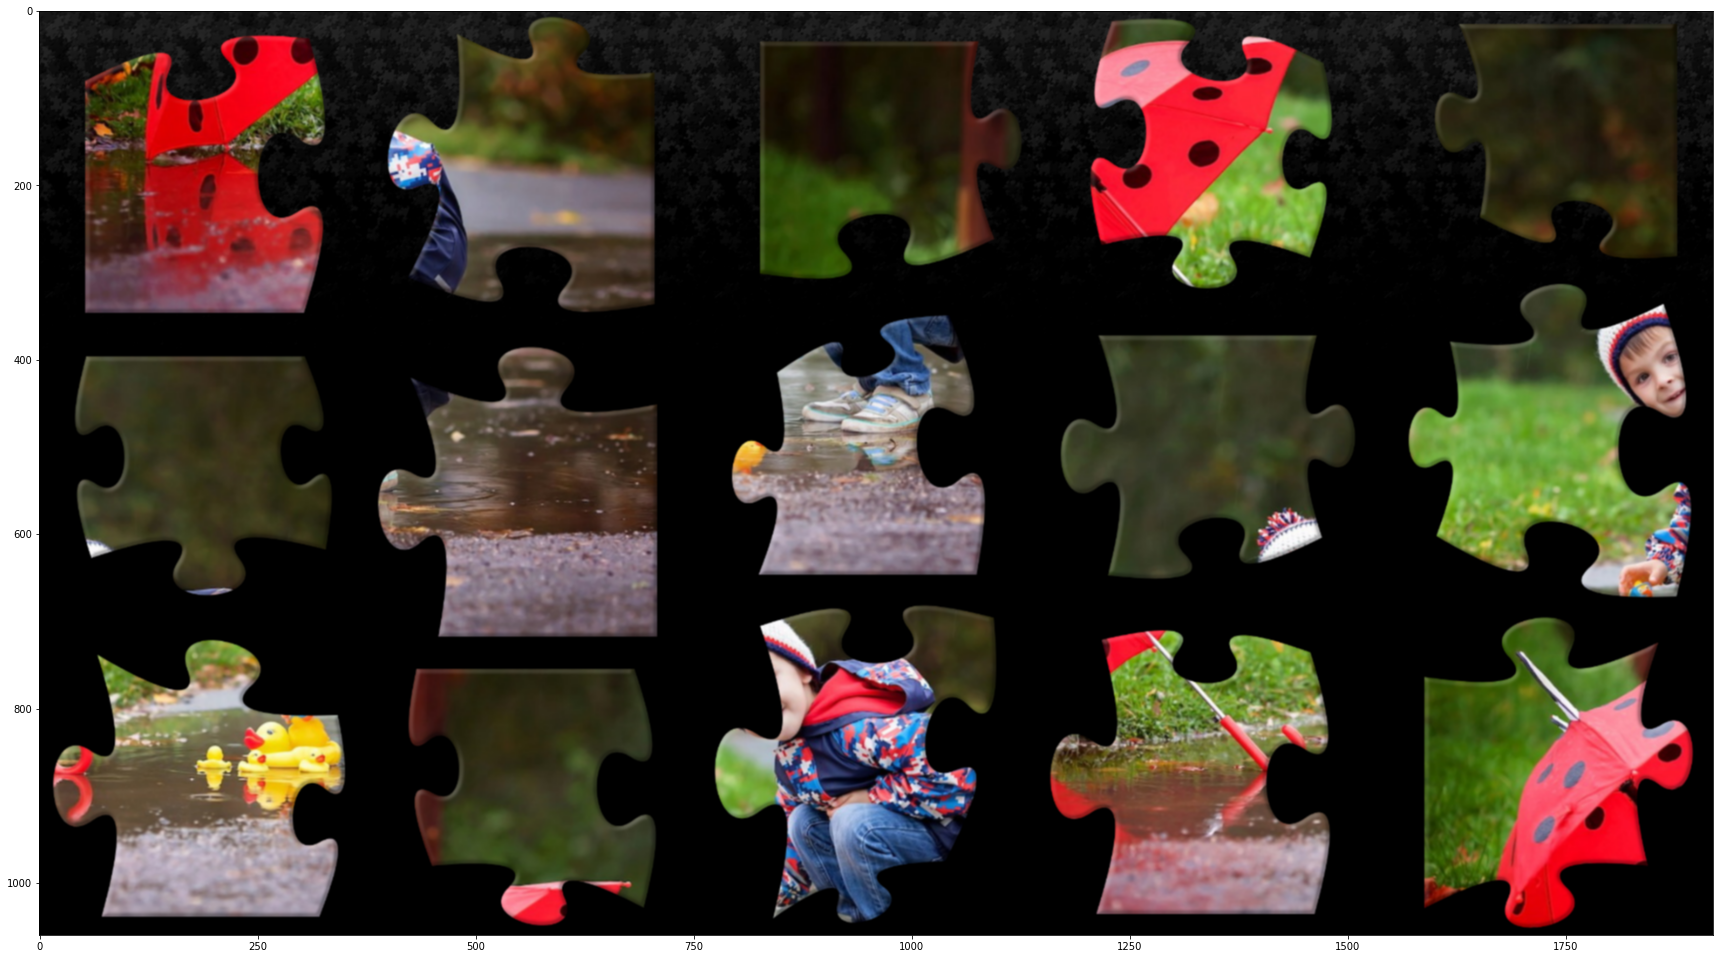

In [6]:
img = cv2.imread("./puzzle.png",1)
rgb_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
rgb_img = cv2.GaussianBlur(rgb_img,(3,3),0)
plt.imshow(rgb_img)

In [7]:
#Change the subplot parameters
plt.rcParams['figure.figsize'] = [5, 5]
rc('xtick', labelsize=10) 
rc('ytick', labelsize=10) 

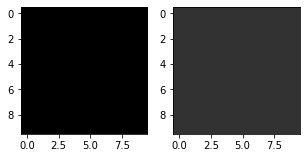

In [8]:
lower_mask = (0, 0, 0)
upper_mask = (0, 0, 50)

low_square = np.full((10, 10, 3), lower_mask, dtype=np.uint8) / 255.0
up_square = np.full((10, 10, 3), upper_mask, dtype=np.uint8) / 255.0

plt.subplot(1,2,1), plt.imshow(hsv_to_rgb(low_square));
plt.subplot(1,2,2), plt.imshow(hsv_to_rgb(up_square));

In [9]:
#Change the subplot parameters 
plt.rcParams['figure.figsize'] = [20, 10]
rc('xtick', labelsize=10) 
rc('ytick', labelsize=10) 

(<matplotlib.axes._subplots.AxesSubplot at 0x7fb1370a3c18>,
 <matplotlib.image.AxesImage at 0x7fb137076cf8>)

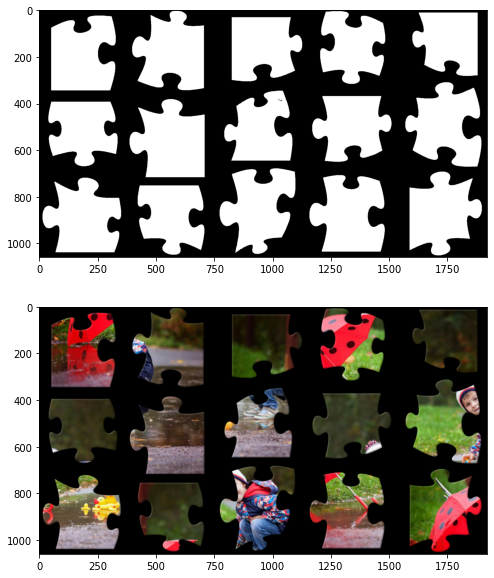

In [10]:
hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
mask = cv2.inRange(hsv_img, lower_mask, upper_mask)
mask = cv2.bitwise_not(mask)
result = cv2.bitwise_and(rgb_img, rgb_img, mask=mask)
# print(mask.max())
plt.subplot(2,1,1), plt.imshow(mask,cmap='gray',vmax=255, vmin=0)
plt.subplot(2,1,2), plt.imshow(result)

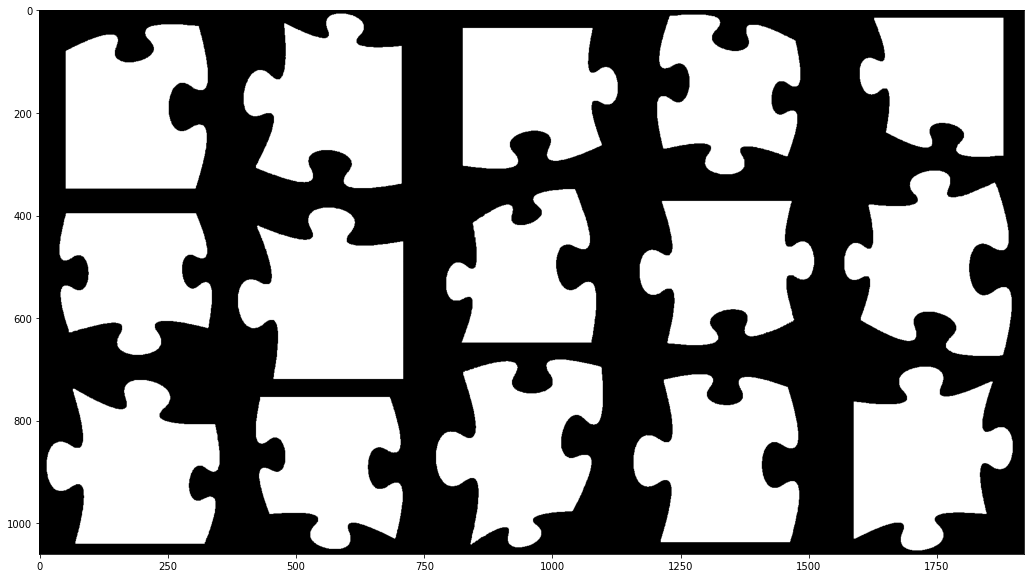

In [11]:
#Rectangle kernel can be replaced by circular kernel. This change is for smaller patches.
rectangle_kernel = kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, rectangle_kernel, iterations = 2)

plt.imshow(opening, cmap='gray')

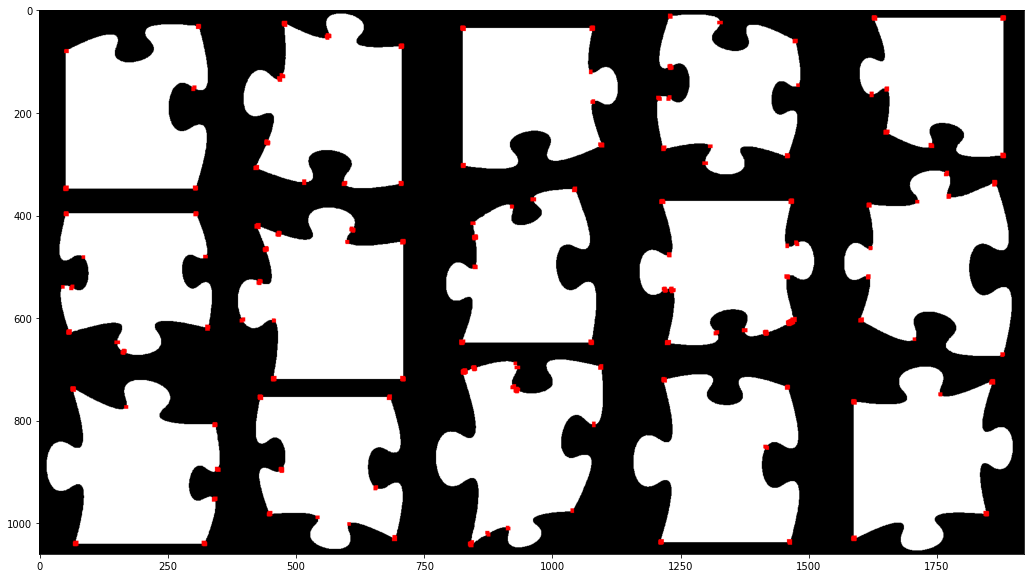

In [12]:
gray = np.copy(opening)

gray = np.float32(gray)
dst = cv2.cornerHarris(gray,5,3,0.12)

#Dilate the corners to make them easier to see.
dst = cv2.dilate(dst,None,iterations=3)

result = cv2.cvtColor(opening,cv2.COLOR_GRAY2RGB)

#Paint the corners with red color
result[dst>0.01*dst.max()]=[255,0,0]

plt.imshow(result)

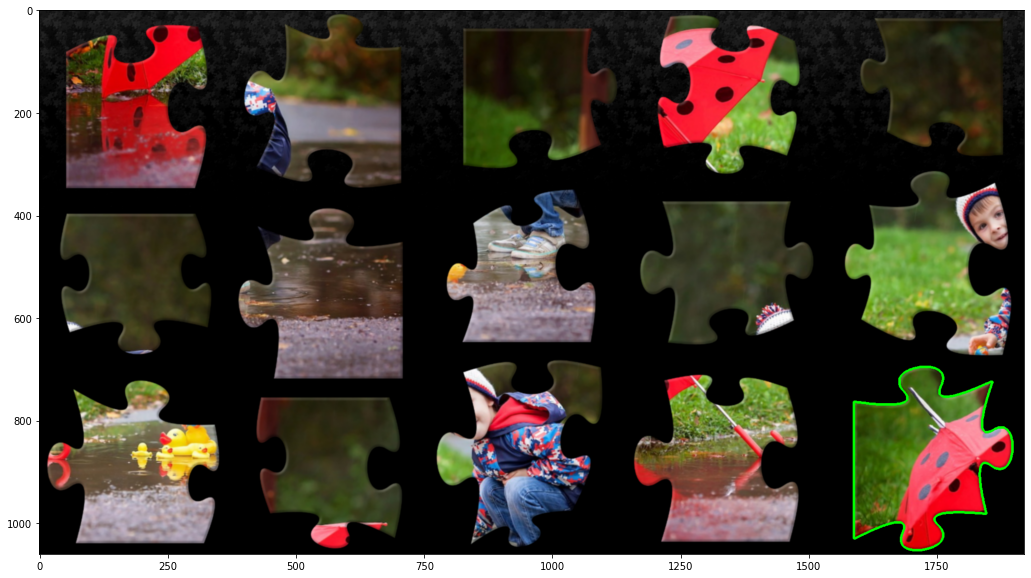

In [13]:
#This block is for validation and debugging
result2 = np.copy(rgb_img)
contours, hierarchy = cv2.findContours(opening, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#Draw one of the contours to check whether it finds the contours.
cv2.drawContours(result2, contours, 3, (0,255,0), 3)
plt.imshow(result2)

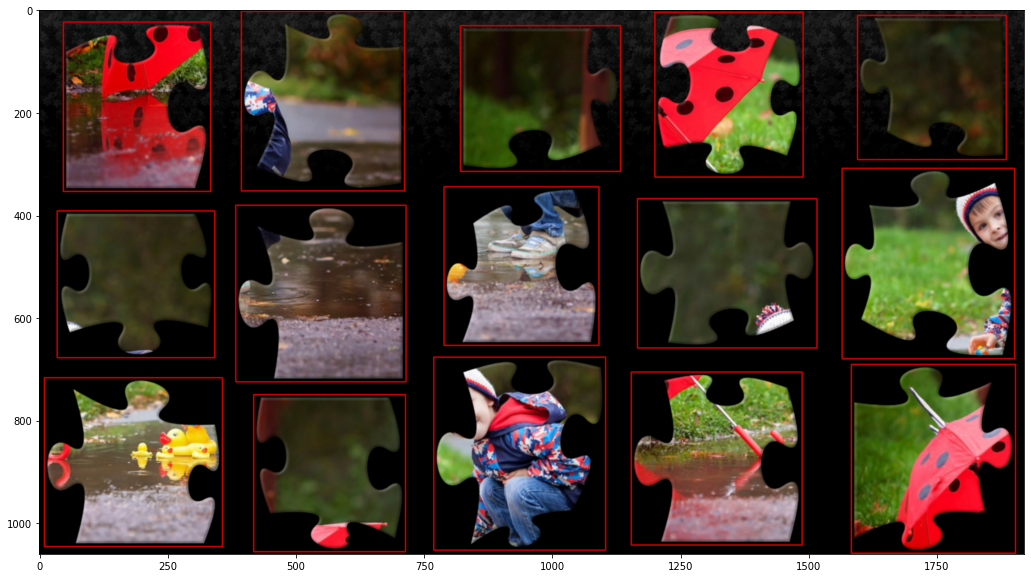

In [14]:
result3 = np.copy(rgb_img)
result3_rgb = cv2.cvtColor(result3,cv2.COLOR_BGR2RGB)
contours, hierarchy = cv2.findContours(opening, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#cv2.drawContours(result3, contours, 3, (0,255,0), 3)
idx = 0
for cnt in contours:
    idx += 1
    x, y, w, h = cv2.boundingRect(cnt)
    roi = result3_rgb[y-5:y + h+5, x-5:x + w+5]
    cv2.imwrite("./colored_parts/"+str(idx) + '.png', roi)
    cv2.rectangle(result3, (x-5, y-5), (x + w+5, y + h+5), (200, 0, 0), 2)
plt.imshow(result3)

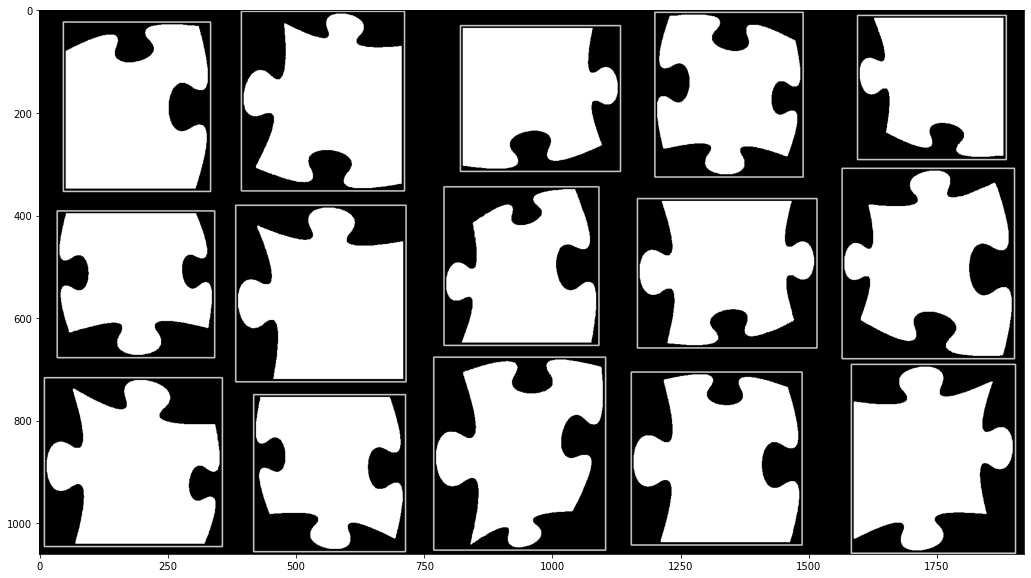

In [15]:
rectangle_drawn = np.copy(opening)
idx = 0
for cnt in contours:
    idx += 1
    x, y, w, h = cv2.boundingRect(cnt)
    roi = opening[y-5:y + h+5, x-5:x + w+5]
    cv2.imwrite("./parts/"+str(idx) + '.png', roi)
    cv2.rectangle(rectangle_drawn, (x-5, y-5), (x + w+5, y + h+5), (200, 0, 0), 2)
plt.imshow(rectangle_drawn,cmap='gray')

In [16]:
imagePaths = readAllImages("parts")
imagePaths_rgb = readAllImages("colored_parts")
list.sort(imagePaths)
list.sort(imagePaths_rgb)
patch_list = []
for i in range(len(imagePaths)):
    patch = Patch(i+1,imagePaths[i],imagePaths_rgb[i])
    patch.pipeLine()
    patch_list.append(patch)
print(len(patch_list))

15


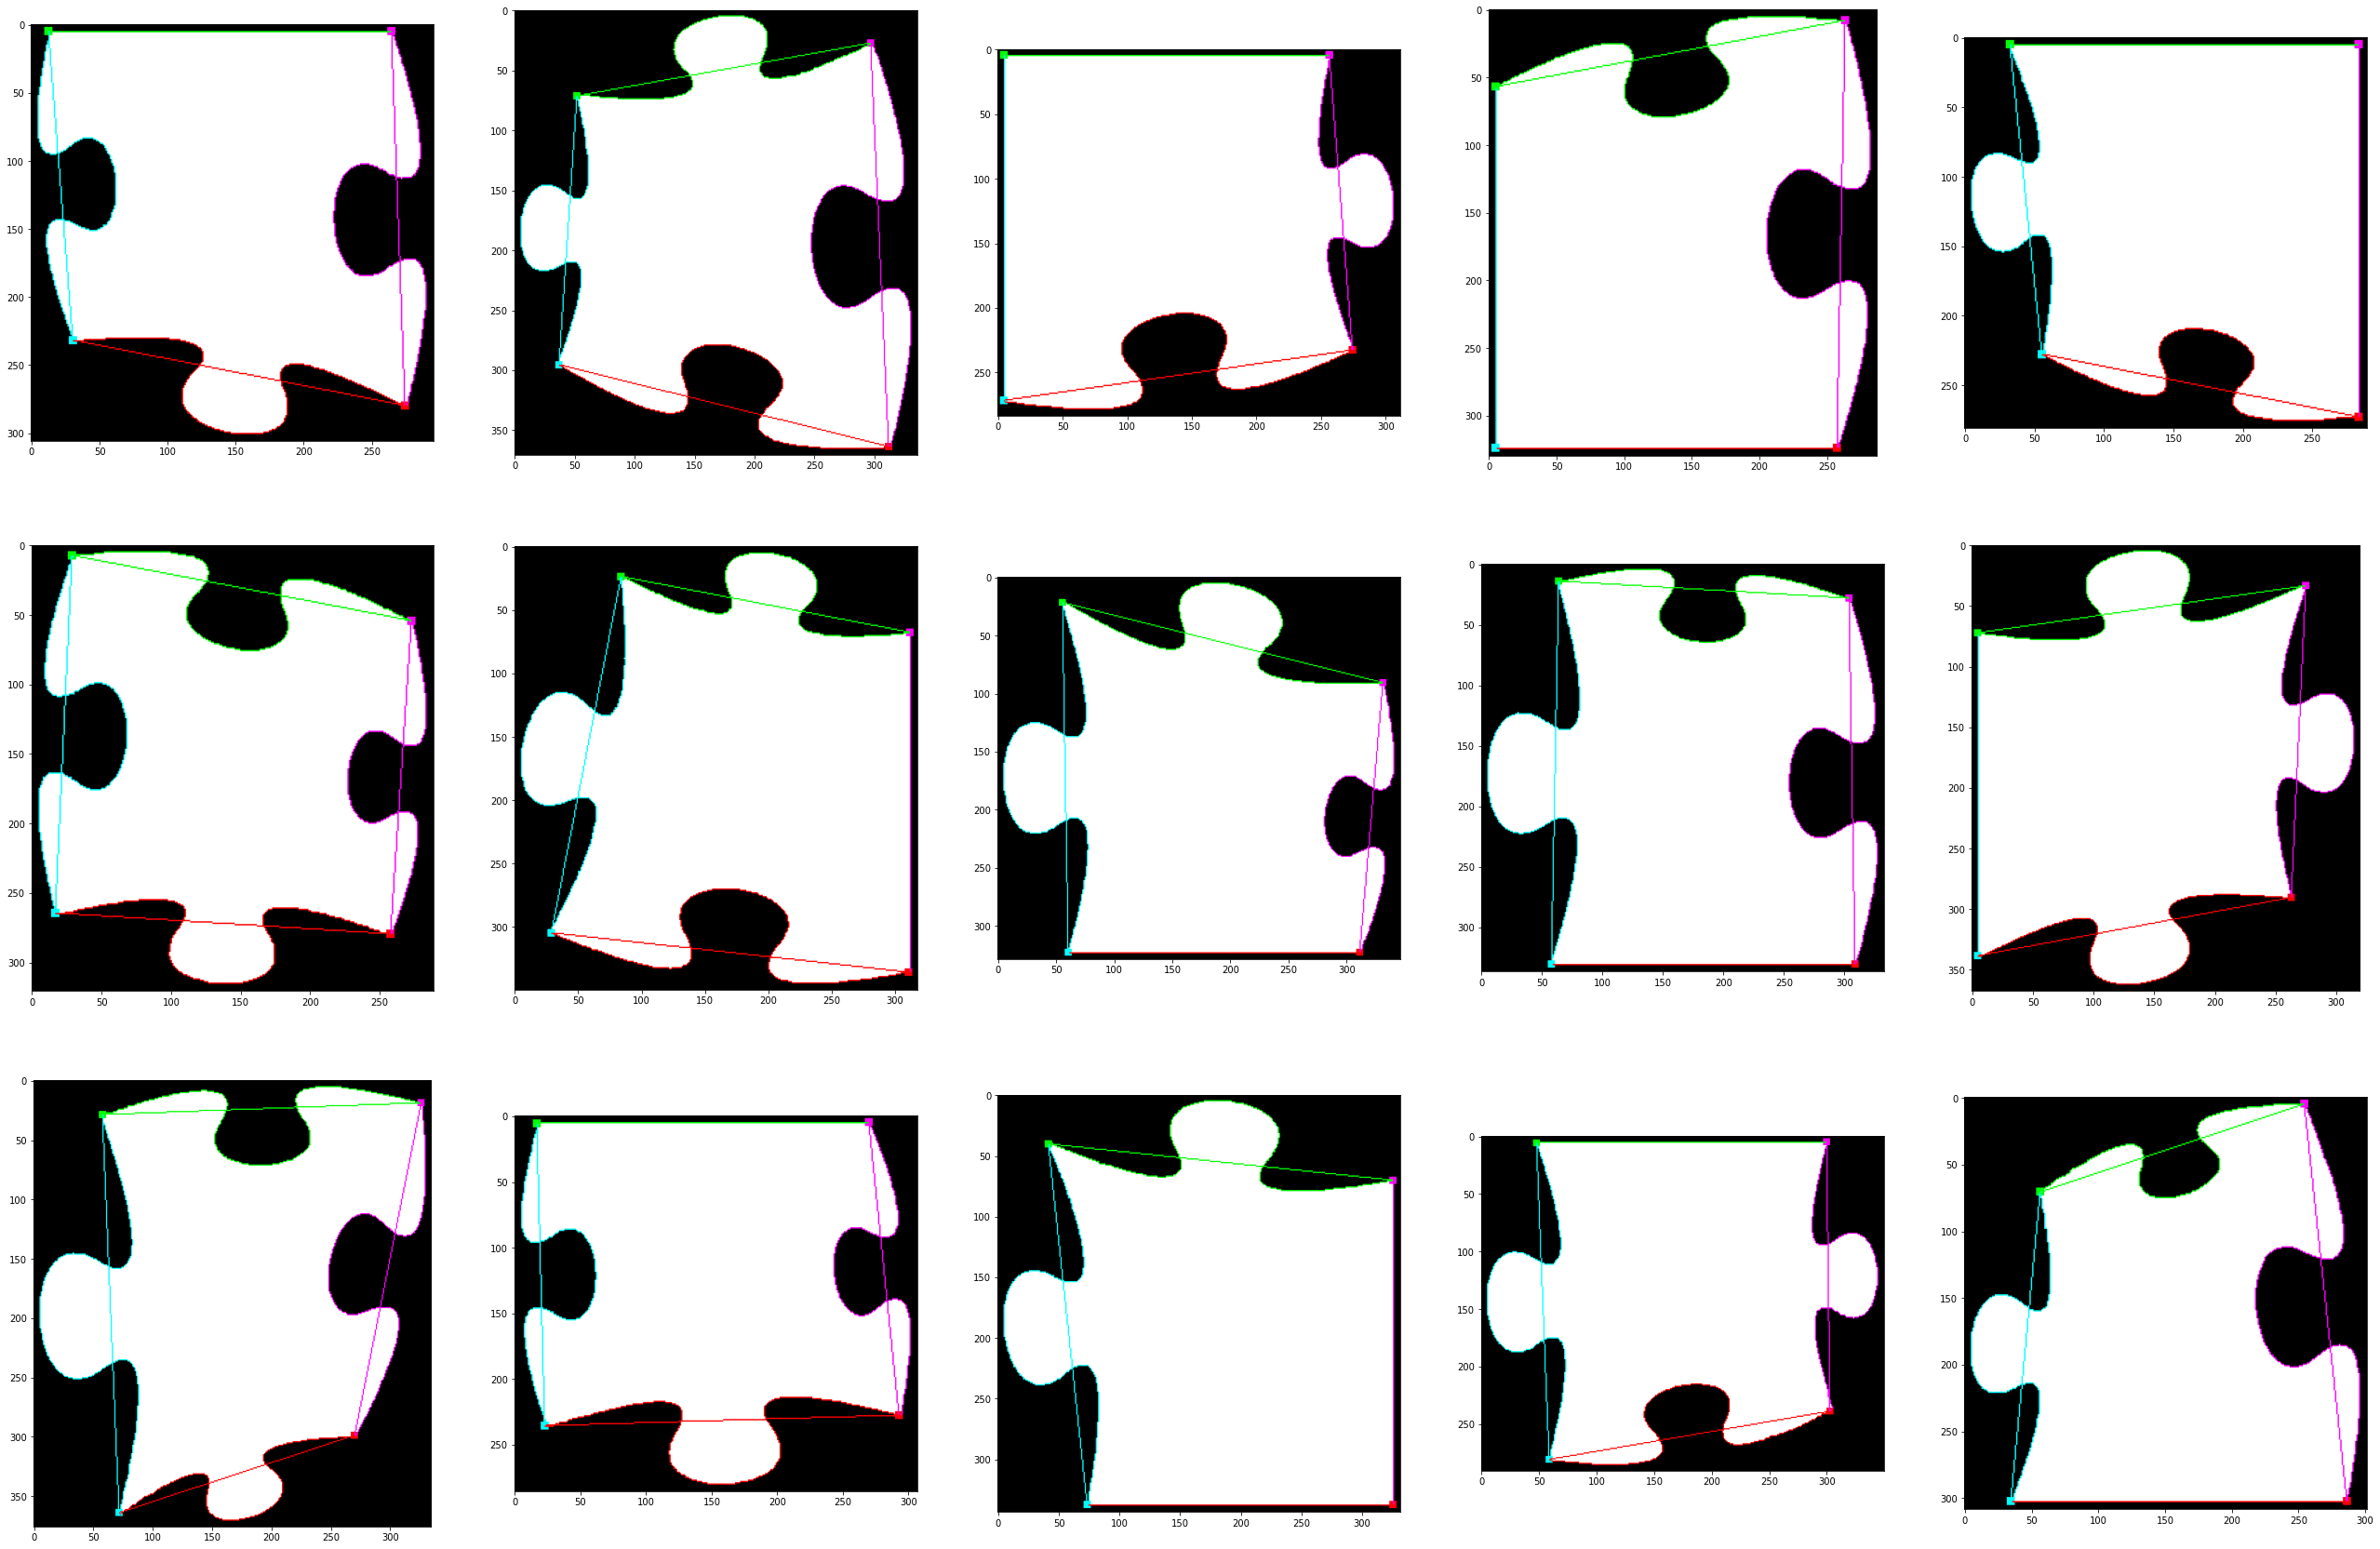

In [17]:
plt.rcParams['figure.figsize'] = [45,30]
rc('xtick', labelsize=10) 
rc('ytick', labelsize=10)

# for i in range(len(patch_list)):
#     plt.subplot(len(patch_list),1,i+1),plt.imshow(patch_list[i].getEdgeImage())
#     up,right,low,left = patch_list[i].getEdgeSlopes()
#     print("{0},{1},{2},{3}".format(up,right,low,left))
#     print("{0},{1},{2},{3}".format(up,right,low,left))
ct = 0
index = 1
for i in range(5):
    for j in range(3):
        plt.subplot(3,5,index),plt.imshow(patch_list[ct].getEdgeImage())
        ct+=1
        index += 1

In [18]:
#Change the subplot parameters
plt.rcParams['figure.figsize'] = [15, 15]
rc('xtick', labelsize=10) 
rc('ytick', labelsize=10)

In [19]:
h_dim = 5 #int(input("Enter horizontal dimension of puzzle:"))
v_dim = 3 #int(input("Enter vertical dimension of puzzle:"))
puzzle = Puzzle(h_dim,v_dim,patch_list)
print(puzzle.getBoard())

Enter horizontal dimension of puzzle:5
Enter vertical dimension of puzzle:3
[[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]


In [20]:
puzzle.findCornerPatches()

Upper left corner: 2
Lower left corner: 3
Upper right corner: 4
Lower right corner: 12


In [21]:
puzzle.findUpperPatches()

0
8
9
upper match w.r.t left-right edge
0
upper match w.r.t left-right edge
9
upper match w.r.t left-right edge
8
Upper row is complete


In [22]:
puzzle.findLowerPatches()

3
4
7
lower match w.r.t left-right edge
4
lower match w.r.t left-right edge
3
lower match w.r.t left-right edge
7
Lower row is complete


In [23]:
puzzle.findLeftPatches()

3
left match w.r.t lower-upper edge
3
Left row is complete


In [24]:
puzzle.findRightPatches()

2
right match w.r.t lower-upper edge
2
Right row is complete


In [25]:
puzzle.findInnerPatches()

Upper & Left match
Column-1 is vertically valid
Upper & Left match
Column-2 is vertically valid
Upper & Left match
Row-1 is horizontally valid
Column-3 is vertically valid


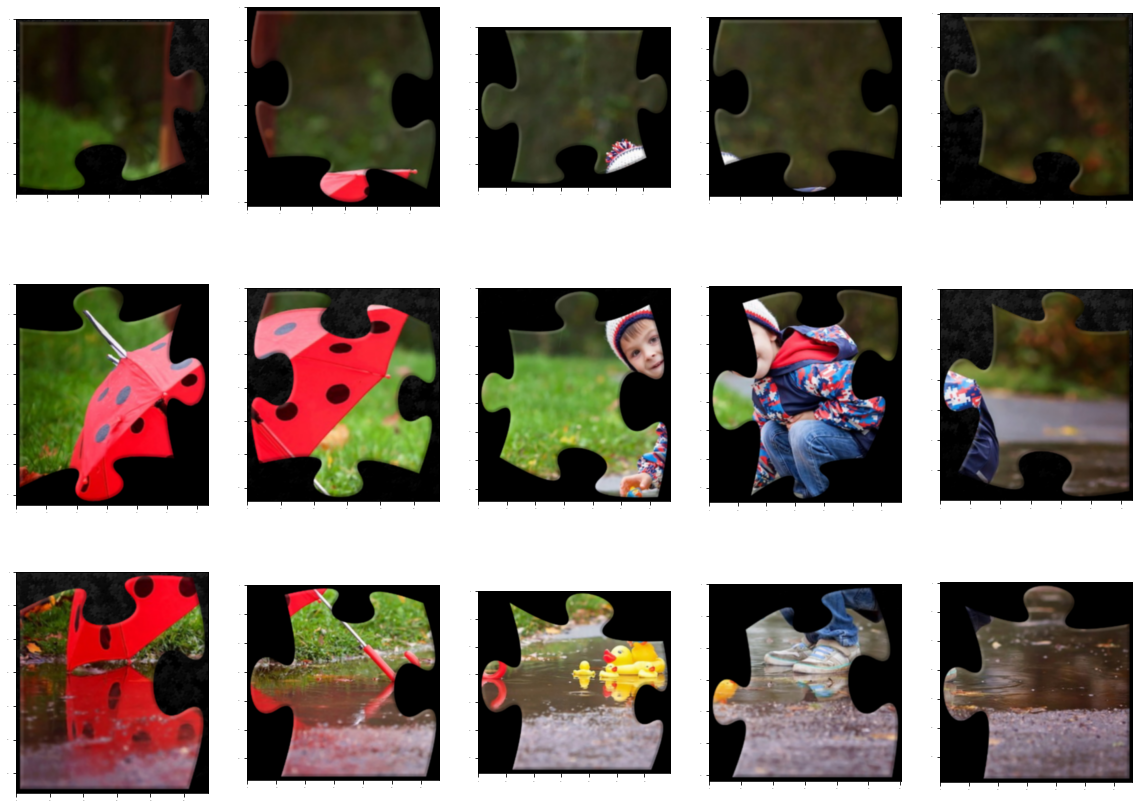

In [26]:
#Change the subplot parameters in order to show all the histograms clearly. 
plt.rcParams['figure.figsize'] = [20, 15]
rc('xtick', labelsize=0) 
rc('ytick', labelsize=0)

board = puzzle.getBoard()
i=0
for x in range(puzzle.y):
    for y in range(puzzle.x):
        plt.subplot(puzzle.y,puzzle.x,i+1),plt.imshow(cv2.cvtColor(board[x][y].getOriginalImageRGB(),cv2.COLOR_RGB2BGR))
        i += 1